<a href="https://colab.research.google.com/github/Mollylst/DeepFake-Project/blob/main/1DDCT_2DDCT_HighComponents.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd 
import matplotlib.pyplot as plt 
import torch
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

%matplotlib inline

Covert the dataset to csv file

In [ ]:
import os
import pandas as pd

os.chdir(rb'/content/drive/MyDrive/real_and_fake_face')

folders = ['0', '1']

files = []

for folder in folders:
    for file in os.listdir(folder):
        files.append([file, folder])

pd.DataFrame(files, columns=['inputs', 'labels']).to_csv('files_and_labels.csv')

Get the 1D power spectrum of an image

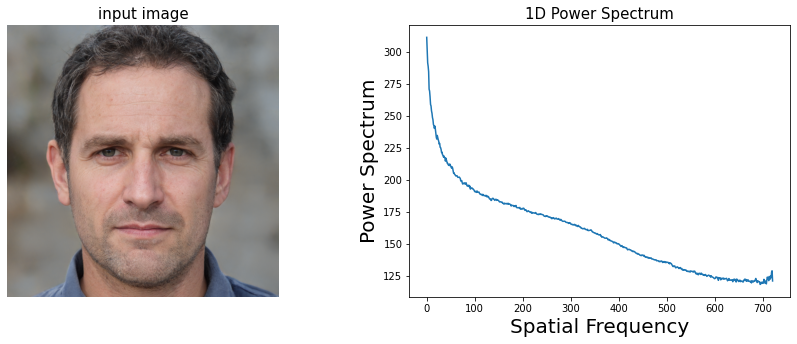

In [ ]:
import math
from scipy import fftpack
from astropy.io import fits
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import cv2
import pylab as py

def azimuthalAverage(image, center=None):
    """
    Calculate the azimuthally averaged radial profile.

    image - The 2D image
    center - The [x,y] pixel coordinates used as the center. The default is 
             None, which then uses the center of the image (including 
             fracitonal pixels).
    
    """
    # Calculate the indices from the image
    y, x = np.indices(image.shape)

    if not center:
        center = np.array([(x.max()-x.min())/2.0, (x.max()-x.min())/2.0])

    r = np.hypot(x - center[0], y - center[1])

    # Get sorted radii
    ind = np.argsort(r.flat)
    r_sorted = r.flat[ind]
    i_sorted = image.flat[ind]

    # Get the integer part of the radii (bin size = 1)
    r_int = r_sorted.astype(int)

    # Find all pixels that fall within each radial bin.
    deltar = r_int[1:] - r_int[:-1]  # Assumes all radii represented
    rind = np.where(deltar)[0]       # location of changed radius
    nr = rind[1:] - rind[:-1]        # number of radius bin
    
    # Cumulative sum to figure out sums for each radius bin
    csim = np.cumsum(i_sorted, dtype=float)
    tbin = csim[rind[1:]] - csim[rind[:-1]]

    radial_prof = tbin / nr

    return radial_prof

def dct2(array):
    array = fftpack.dct(array, type=2, norm="ortho", axis=0)
    array = fftpack.dct(array, type=2, norm="ortho", axis=1)
    return array

def log_scale(array, epsilon=1e-12):
    """Log scale the input array.
    """
    array = np.abs(array)
    array += epsilon  # no zero in log
    array = np.log(array)
    return array

epsilon = 1e-8
filename = '/content/drive/MyDrive/Colab Notebooks/Visualizing channels in intermediate activation/000001.jpg'

img = cv2.imread(filename,0)
img_color = mpimg.imread(filename)
# Calculate FFT
f = np.fft.fft2(img)
fshift = np.fft.fftshift(f)
fshift += epsilon
magnitude_spectrum = 20*np.log(np.abs(fshift))
# Calculate the azimuthally averaged 1D power spectrum
psd1D = azimuthalAverage(magnitude_spectrum)

#Visualization
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(121)
plt.axis('off')
ax2 = fig.add_subplot(122)
ax.set_title('input image',size=15)
ax2.set_title('1D Power Spectrum',size=15)
plt.xlabel('Spatial Frequency', fontsize=20)
plt.ylabel('Power Spectrum', fontsize=20)
ax.imshow(img_color)
ax2.plot(psd1D)
plt.show()

Get the 2D power spectrum of an image

(([], <a list of 0 Text major ticklabel objects>),
 ([], <a list of 0 Text major ticklabel objects>))

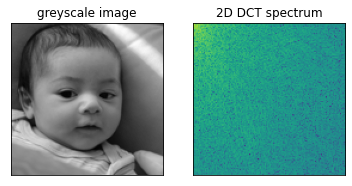

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

#img = cv2.imread('/content/drive/MyDrive/dataset_20000_6.4:1.6:2/test/fake/000022.png', 0)
img = cv2.imread('/content/drive/MyDrive/Colab Notebooks/Visualizing channels in intermediate activation/00000_output.png',0)

img1 = img.astype('float')
img_dct = cv2.dct(img1)        
img_dct_log = np.log(abs(img_dct))  

plt.subplot(121)
plt.imshow(img1, 'gray')
plt.title('greyscale image')
plt.xticks([]), plt.yticks([])
 
plt.subplot(122)
plt.imshow(img_dct_log)
plt.title('2D DCT spectrum')
plt.xticks([]), plt.yticks([])

Show the high frequecny components of an image

In [ ]:
def create_circular_mask(h, w, center=None, radius=None):

    if center is None: # use the middle of the image
        center = [int(w/2), int(h/2)]
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center <= radius

    return mask

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


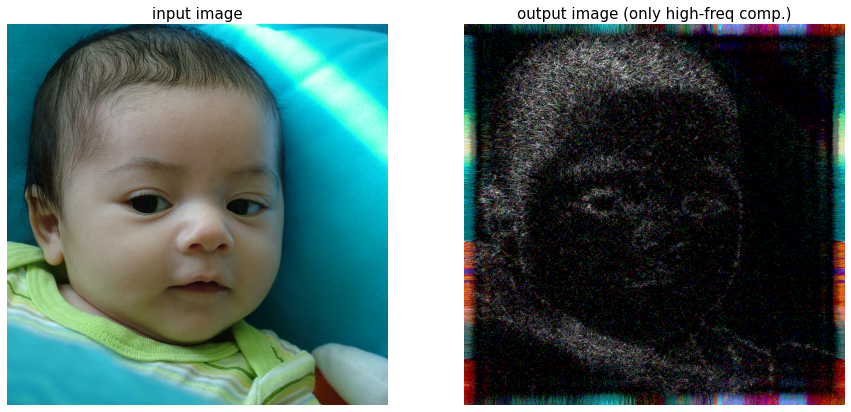

In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
#import radialProfile
import glob

epsilon = 1e-8
filename = '/content/drive/MyDrive/Colab Notebooks/Visualizing channels in intermediate activation/00000.jpg'

mask = create_circular_mask(1024,1024,radius=500)
mask = np.invert(mask)
inv = np.zeros([1024,1024,3])
img_color =[]

# Read image and split color-channels
img_color = mpimg.imread(filename,0)
img_r = img_color[:,:,0]
img_b = img_color[:,:,1]
img_g = img_color[:,:,2]

# Calculate FFT and appply mask for each channel
f_r = np.fft.fft2(img_r)
fshift_r = np.fft.fftshift(f_r)     
fshift_r = fshift_r*mask       
f_ishift_r = np.fft.ifftshift(fshift_r)
img_back_r = np.fft.ifft2(f_ishift_r)
img_back_r = np.abs(img_back_r)

f_b = np.fft.fft2(img_b)
fshift_b = np.fft.fftshift(f_b)
fshift_b = fshift_b*mask   
f_ishift_b = np.fft.ifftshift(fshift_b)
img_back_b = np.fft.ifft2(f_ishift_b)
img_back_b = np.abs(img_back_b)

f_g = np.fft.fft2(img_g)
fshift_g = np.fft.fftshift(f_g)
fshift_g = fshift_g*mask   
f_ishift_g = np.fft.ifftshift(fshift_g)
img_back_g = np.fft.ifft2(f_ishift_g)
img_back_g = np.abs(img_back_g)

inv[:,:,0] = np.round(img_back_r)/255
inv[:,:,1] = np.round(img_back_b)/255
inv[:,:,2] = np.round(img_back_g)/255

# Visualization
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(121)
plt.axis('off')
ax2 = fig.add_subplot(122)
plt.axis('off')

# Weightning for enhance visualization
inv2 = np.copy(inv)
inv2 /= inv.max()
inv2 *= 4

ax.set_title('input image',size=15)
ax.imshow(img_color)
ax2.set_title('output image (only high-freq comp.)',size=15)
ax2.imshow(inv2)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


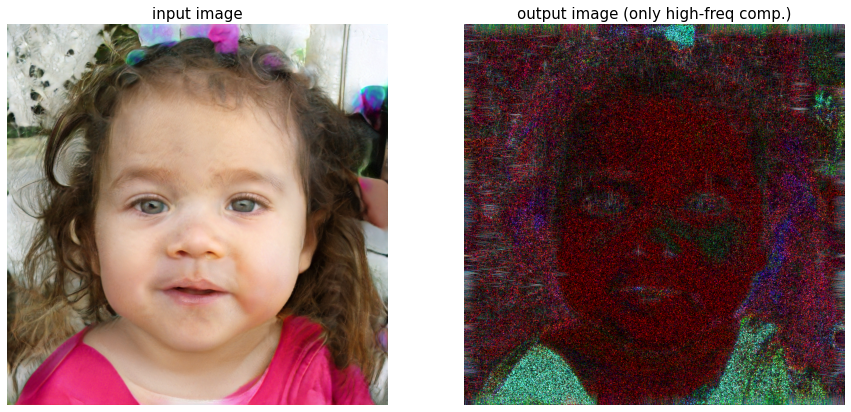

In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
#import radialProfile
import glob

epsilon = 1e-8
filename = '/content/drive/MyDrive/Colab Notebooks/Visualizing channels in intermediate activation/000028.jpg'

mask = create_circular_mask(1024,1024,radius=500)
mask = np.invert(mask)
inv = np.zeros([1024,1024,3])
img_color =[]

# Read image and split color-channels
img_color = mpimg.imread(filename)
img_r = img_color[:,:,0]
img_b = img_color[:,:,1]
img_g = img_color[:,:,2]

# Calculate FFT and appply mask for each channel
f_r = np.fft.fft2(img_r)
fshift_r = np.fft.fftshift(f_r)     
fshift_r = fshift_r*mask       
f_ishift_r = np.fft.ifftshift(fshift_r)
img_back_r = np.fft.ifft2(f_ishift_r)
img_back_r = np.abs(img_back_r)

f_b = np.fft.fft2(img_b)
fshift_b = np.fft.fftshift(f_b)
fshift_b = fshift_b*mask   
f_ishift_b = np.fft.ifftshift(fshift_b)
img_back_b = np.fft.ifft2(f_ishift_b)
img_back_b = np.abs(img_back_b)

f_g = np.fft.fft2(img_g)
fshift_g = np.fft.fftshift(f_g)
fshift_g = fshift_g*mask   
f_ishift_g = np.fft.ifftshift(fshift_g)
img_back_g = np.fft.ifft2(f_ishift_g)
img_back_g = np.abs(img_back_g)

inv[:,:,0] = np.round(img_back_r)/255
inv[:,:,1] = np.round(img_back_b)/255
inv[:,:,2] = np.round(img_back_g)/255

# Visualization
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(121)
plt.axis('off')
ax2 = fig.add_subplot(122)
plt.axis('off')

# Weightning for enhance visualization
inv2 = np.copy(inv)
inv2 /= inv.max()
inv2 *= 4

ax.set_title('input image',size=15)
ax.imshow(img_color)
ax2.set_title('output image (only high-freq comp.)',size=15)
ax2.imshow(inv2)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


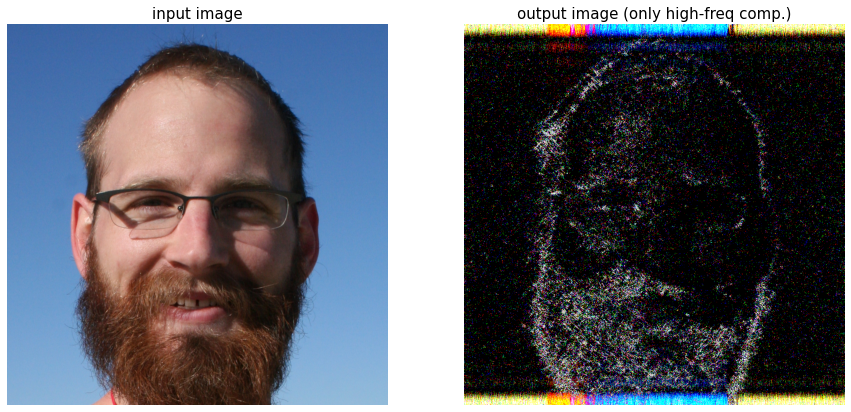

In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
#import radialProfile
import glob

epsilon = 1e-8
filename = '/content/drive/MyDrive/Colab Notebooks/Visualizing channels in intermediate activation/00042.jpg'

mask = create_circular_mask(1024,1024,radius=500)
mask = np.invert(mask)
inv = np.zeros([1024,1024,3])
img_color =[]

# Read image and split color-channels
img_color = mpimg.imread(filename)
img_r = img_color[:,:,0]
img_b = img_color[:,:,1]
img_g = img_color[:,:,2]

# Calculate FFT and appply mask for each channel
f_r = np.fft.fft2(img_r)
fshift_r = np.fft.fftshift(f_r)     
fshift_r = fshift_r*mask       
f_ishift_r = np.fft.ifftshift(fshift_r)
img_back_r = np.fft.ifft2(f_ishift_r)
img_back_r = np.abs(img_back_r)

f_b = np.fft.fft2(img_b)
fshift_b = np.fft.fftshift(f_b)
fshift_b = fshift_b*mask   
f_ishift_b = np.fft.ifftshift(fshift_b)
img_back_b = np.fft.ifft2(f_ishift_b)
img_back_b = np.abs(img_back_b)

f_g = np.fft.fft2(img_g)
fshift_g = np.fft.fftshift(f_g)
fshift_g = fshift_g*mask   
f_ishift_g = np.fft.ifftshift(fshift_g)
img_back_g = np.fft.ifft2(f_ishift_g)
img_back_g = np.abs(img_back_g)

inv[:,:,0] = np.round(img_back_r)/255
inv[:,:,1] = np.round(img_back_b)/255
inv[:,:,2] = np.round(img_back_g)/255

# Visualization
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(121)
plt.axis('off')
ax2 = fig.add_subplot(122)
plt.axis('off')

# Weightning for enhance visualization
inv2 = np.copy(inv)
inv2 /= inv.max()
inv2 *= 4

ax.set_title('input image',size=15)
ax.imshow(img_color)
ax2.set_title('output image (only high-freq comp.)',size=15)
ax2.imshow(inv2)
plt.show()